In [171]:
import shutil
import os

# Delete the 'eda' folder if it exists
if os.path.exists('eda'):
    shutil.rmtree('eda')
    print("Deleted existing 'eda' folder.")

Deleted existing 'eda' folder.


In [172]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import re
import os
from datetime import datetime

In [173]:
config = {
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    "test_selection": "2nd_from_top_and_bottom",  # "random" or "2nd_from_top_and_bottom"
    # "test_selection": "random",  # "random" or "2nd_from_top_and_bottom"
    "ignore_e8_e9": True,
    "remove_small_errors": True,
    "zooms": ['z2'], # ['z1'] or ['z2'] or ['z1', 'z2']
    "model_": "MultiOutputClassifier",
    "model": "TwoStageClassifier",
    "parameter_loss_weight": 1.0  # Weight for parameter loss in combined loss
}

### Load Data and Initial Processing

In [174]:
# Load the CSV data
print("Loading CSV data...")
df = pd.read_excel("/content/Lab_Sensitivity_results 680204 (15)_ver C_twoZooms_20250908.xlsx", sheet_name='Sheet1')

# Remove "Nominal" rows
df = df[df["name"] != "Nominal"]

Loading CSV data...


In [175]:
# Split the name into error_name and parameter_name
def split_parameter_name(name):
    """Split parameter name into error type and element"""
    # Find the last part that matches E followed by number or G followed by number
    match = re.search(r'(E\d+|G\d+)$', name)
    if match:
        parameter_name = match.group(1)
        error_name = name.replace(parameter_name, '').strip()
        return error_name, parameter_name
    else:
        # If no match, return the whole name as error_name and empty parameter_name
        return name, ""

# Apply the split
df[['error_name', 'parameter_name']] = df['name'].apply(
    lambda x: pd.Series(split_parameter_name(x))
)

# keep only the rows with the specified zooms
df = df[df["efl"].isin(config["zooms"])]
display(df)
print("\nUnique error names:")
print(df['error_name'].unique())
print(f"\nUnique parameter names:")
print(df['parameter_name'].unique())

,name,error,freq,efl,c2,c3,c4,c5,c6,c7,...,c31,c32,c33,c34,c35,c36,c37,MTF,error_name,parameter_name
3,Radius s1 E1,-0.01000,25,z2,-7.831192e-14,-7.895894e-16,-0.009331,3.891984e-14,-2.691255e-13,-5.131977e-14,...,-1.601313e-13,3.335577e-14,1.354420e-13,-1.806633e-13,-5.364807e-14,-0.000084,0.000004,0.425583,Radius s1,E1
5,Radius s1 E1,-0.00750,25,z2,-2.177818e-13,-2.390434e-13,-0.009277,5.243379e-14,-2.550493e-13,-9.483065e-14,...,-2.570473e-13,-1.843717e-14,-1.762823e-13,-4.886340e-14,1.080607e-13,-0.000084,0.000004,0.425577,Radius s1,E1
7,Radius s1 E1,-0.00500,25,z2,-4.165981e-13,-4.296608e-13,-0.009223,3.385654e-14,-8.975590e-14,-1.774126e-13,...,5.140993e-13,3.827574e-14,-3.599705e-13,-9.738805e-14,-7.610032e-14,-0.000084,0.000004,0.425571,Radius s1,E1
9,Radius s1 E1,-0.00250,25,z2,3.653297e-13,3.559784e-13,-0.009169,-3.282457e-14,3.130311e-15,3.854093e-13,...,-2.289406e-13,-3.535281e-14,3.459461e-13,1.245720e-13,7.670740e-14,-0.000085,0.000004,0.425565,Radius s1,E1
11,Radius s1 E1,-0.00100,25,z2,-1.365693e-13,-7.950521e-14,-0.009136,-7.328153e-14,-1.429621e-14,-2.876918e-13,...,6.978208e-14,8.631412e-14,1.172750e-13,4.865138e-13,4.549173e-13,-0.000085,0.000004,0.425561,Radius s1,E1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,Tilt E7,0.00025,25,z2,-9.851568e-14,-3.878940e-03,-0.009190,-2.926732e-07,-4.702435e-13,-1.008709e-13,...,-4.703836e-10,-3.341847e-10,3.735317e-13,-2.175979e-13,-8.106875e-08,-0.000085,0.000004,0.425532,Tilt,E7
1255,Tilt E7,0.00050,25,z2,-4.319758e-14,-7.757890e-03,-0.009193,-1.000000e-06,-2.679859e-13,3.066146e-13,...,-9.446702e-10,-1.313693e-09,1.421455e-13,-2.338160e-13,-1.621256e-07,-0.000085,0.000004,0.425501,Tilt,E7
1257,Tilt E7,0.00100,25,z2,1.621218e-13,-1.551580e-02,-0.009204,-5.000000e-06,-2.272667e-13,-3.453454e-14,...,-2.006766e-09,-5.234852e-09,4.334685e-13,-3.335399e-13,-3.242979e-07,-0.000085,0.000004,0.425374,Tilt,E7
1259,Tilt E7,0.00200,25,z2,-5.352416e-14,-3.103160e-02,-0.009250,-1.900000e-05,2.302112e-13,2.730206e-13,...,-5.612721e-09,-1.612527e-08,2.661504e-13,4.359775e-13,-1.000000e-06,-0.000085,0.000004,0.424869,Tilt,E7



Unique error names:
['Radius s1' 'Radius s2' 'Irr s1' 'Irr s2' 'Thickness' 'ETV' 'Z Position'
 'Decenter' 'Tilt']

Unique parameter names:
['E1' 'E2' 'E3' 'E4' 'E5' 'E6' 'E7']


### Filter Data based on Configuration

### Filter Data based on Configuration

In [176]:
# Find the rows where parameter_name is neither "E8" nor "E9"
# The correct condition is (df["parameter_name"] != "E8") AND (df["parameter_name"] != "E9")
# Note: This assumes the 'parameter_name' column exists in the DataFrame.
# If not, rerun the data loading and splitting steps (cells z_-4mJcD-YWA and d46bc68a).
rows_not_e8_e9 = df[(df["parameter_name"] != "E8") & (df["parameter_name"] != "E9")]

# Display the index of these rows (which are the row numbers)
print("Row numbers where parameter_name is neither 'E8' nor 'E9':")
print(rows_not_e8_e9.index.tolist())

print(f"\nNumber of rows where parameter_name is neither 'E8' nor 'E9': {len(rows_not_e8_e9)}")

Row numbers where parameter_name is neither 'E8' nor 'E9':
[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 383, 385, 387, 389, 391, 393, 395, 397, 399

In [177]:
# Find the rows where parameter_name is either "E8" or "E9"
rows_e8_or_e9 = df[(df["parameter_name"] == "E8") | (df["parameter_name"] == "E9")]

# Display the index of these rows (which are the row numbers)
print("Row numbers where parameter_name is either 'E8' or 'E9':")
print(rows_e8_or_e9.index.tolist())

print(f"\nNumber of rows where parameter_name is either 'E8' or 'E9': {len(rows_e8_or_e9)}")

Row numbers where parameter_name is either 'E8' or 'E9':
[]

Number of rows where parameter_name is either 'E8' or 'E9': 0


In [178]:
# keep only the rows with the specified zooms
df = df[df["efl"].isin(config["zooms"])]

if config["ignore_e8_e9"]:
    df = df[df["parameter_name"] != "E8"]
    df = df[df["parameter_name"] != "E9"]
'''
if config["remove_small_errors"]:
    # remove the 2 rows with smallest absolute error from each error_name and parameter_name
    df = df.groupby(['error_name', 'parameter_name']).apply(lambda x: x.sort_values(by='error', key=lambda x: abs(x)).iloc[2:])
    df = df.reset_index(drop=True)
'''

print("\nUnique error names:")
print(df['error_name'].unique())
print(f"\nUnique parameter names:")
print(df['parameter_name'].unique())


Unique error names:
['Radius s1' 'Radius s2' 'Irr s1' 'Irr s2' 'Thickness' 'ETV' 'Z Position'
 'Decenter' 'Tilt']

Unique parameter names:
['E1' 'E2' 'E3' 'E4' 'E5' 'E6' 'E7']


### Encode Categorical Variables

In [179]:
# Encode the categorical variables
le_error = LabelEncoder()
le_parameter = LabelEncoder()

df['error_name_encoded'] = le_error.fit_transform(df['error_name'])
df['parameter_name_encoded'] = le_parameter.fit_transform(df['parameter_name'])

print(f"\nNumber of error types: {len(le_error.classes_)}")
print(f"Number of parameter types: {len(le_parameter.classes_)}")

display(le_error.classes_)


Number of error types: 9
Number of parameter types: 7


array(['Decenter', 'ETV', 'Irr s1', 'Irr s2', 'Radius s1', 'Radius s2',
       'Thickness', 'Tilt', 'Z Position'], dtype=object)

### Prepare Features and Create Train/Test Split

In [180]:
# Prepare features (excluding the target columns)
feature_columns = [f'c{i}' for i in range(2, 38)] + ['MTF']

# Create train/test split based on error_name + parameter_name groups
train_data = []
test_data = []

print("\nCreating train/test split...")
# Ensure 'error_name' and 'parameter_name' columns are present in df.
# If not, rerun the data loading and splitting steps (cells above).
for error_name in df['error_name'].unique():
    for parameter_name in df['parameter_name'].unique():
        # Get data for this specific error_name + parameter_name combination
        group_data = df[(df['error_name'] == error_name) &
                       (df['parameter_name'] == parameter_name)]

        if len(group_data) < 4:
            print(f"Skipping {error_name} {parameter_name}: only {len(group_data)} samples")
            continue

        # Sort by error value
        group_data_sorted = group_data.sort_values('error')

        if config["test_selection"] == "random":
            test_indices = np.random.choice(len(group_data_sorted), size=2, replace=False)
        elif config["test_selection"] == "2nd_from_top_and_bottom":
            test_indices = [1, len(group_data_sorted) - 2]  # Second from top and second from bottom
        else:
            raise ValueError(f"Invalid test selection: {config['test_selection']}")

        test_rows = group_data_sorted.iloc[test_indices]
        train_rows = group_data_sorted.drop(group_data_sorted.index[test_indices])

        test_data.extend(test_rows.to_dict('records'))
        train_data.extend(train_rows.to_dict('records'))

# Convert back to DataFrames
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

# Apply One-Hot Encoding to the original categorical columns
df_train_encoded = pd.get_dummies(df_train, columns=['error_name', 'parameter_name'], dtype=int)
df_test_encoded = pd.get_dummies(df_test, columns=['error_name', 'parameter_name'], dtype=int)

print(f"Training set size: {len(df_train_encoded)}")
print(f"Test set size: {len(df_test_encoded)}")


Creating train/test split...
Training set size: 504
Test set size: 126


In [181]:
# Define the list of test columns based on the specified pattern
test_error_columns = [f'error_name_{cls}' for cls in le_error.classes_]
test_parameter_columns = [f'parameter_name_E{i}' for i in range(1, 8)]

print("Test columns:")
print(test_error_columns)
print(test_parameter_columns)

# Prepare features and targets
X_train = df_train_encoded[feature_columns].values
X_test = df_test_encoded[feature_columns].values

y_error_train = df_train_encoded[test_error_columns].values
y_error_test = df_test_encoded[test_error_columns].values

y_parameter_train = df_train_encoded[test_parameter_columns].values
y_parameter_test = df_test_encoded[test_parameter_columns].values

Test columns:
['error_name_Decenter', 'error_name_ETV', 'error_name_Irr s1', 'error_name_Irr s2', 'error_name_Radius s1', 'error_name_Radius s2', 'error_name_Thickness', 'error_name_Tilt', 'error_name_Z Position']
['parameter_name_E1', 'parameter_name_E2', 'parameter_name_E3', 'parameter_name_E4', 'parameter_name_E5', 'parameter_name_E6', 'parameter_name_E7']


### Scale Features

In [182]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature shapes:")
print(f"X_train: {X_train_scaled.shape}")
print(f"X_test: {X_test_scaled.shape}")
print(f"y_error_train: {y_error_train.shape}")
print(f"y_parameter_train: {y_parameter_train.shape}")


Feature shapes:
X_train: (504, 37)
X_test: (126, 37)
y_error_train: (504, 9)
y_parameter_train: (504, 7)


### Create PyTorch Datasets and DataLoaders

In [183]:
# Create PyTorch Dataset
class OpticalDataset(Dataset):
    def __init__(self, X, y_error, y_parameter):
        self.X = torch.tensor(X, dtype=torch.float32)
        # Change target dtype to float32 for one-hot encoded targets
        self.y_error = torch.tensor(y_error, dtype=torch.float32)
        self.y_parameter = torch.tensor(y_parameter, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_error[idx], self.y_parameter[idx]

In [184]:
# Create datasets - transforming the feature and targets to PyTorch tensors
train_dataset = OpticalDataset(X_train_scaled, y_error_train, y_parameter_train)
test_dataset = OpticalDataset(X_test_scaled, y_error_test, y_parameter_test)

In [185]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# Get a batch from the training data loader
X_batch, y_error_batch, y_parameter_batch = next(iter(train_loader))

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Data loaders created:
Training batches: 16
Test batches: 4


### Test DataLoaders

In [186]:
# Test the data loaders
print(f"\nTesting data loaders...")
for batch_idx, (X_batch, y_error_batch, y_parameter_batch) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  X shape: {X_batch.shape}")
    print(f"  y_error shape: {y_error_batch.shape}")
    print(f"  y_parameter shape: {y_parameter_batch.shape}")
    print(f"  y_error range: {y_error_batch.min().item()} to {y_error_batch.max().item()}")
    print(f"  y_parameter range: {y_parameter_batch.min().item()} to {y_parameter_batch.max().item()}")
    break

print(f"\nData preparation complete! Ready for neural network training.")


Testing data loaders...
Batch 1:
  X shape: torch.Size([32, 37])
  y_error shape: torch.Size([32, 9])
  y_parameter shape: torch.Size([32, 7])
  y_error range: 0.0 to 1.0
  y_parameter range: 0.0 to 1.0

Data preparation complete! Ready for neural network training.


### Save Encoders, Scaler, and Configuration

In [187]:
# Create timestamped directory for results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"eda/plots/neural_network_results_{timestamp}"
os.makedirs(results_dir, exist_ok=True)
print(f"\nResults will be saved to: {results_dir}")


Results will be saved to: eda/plots/neural_network_results_20251017_000226


In [188]:
# Save the encoders and scaler for later use
import pickle
import os
from datetime import datetime

# Create timestamped directory for results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = f"eda/plots/neural_network_results_{timestamp}"
os.makedirs(results_dir, exist_ok=True)
print(f"\nResults will be saved to: {results_dir}")

with open(f'{results_dir}/encoders_and_scaler.pkl', 'wb') as f:
    pickle.dump({
        'le_error': le_error,
        'le_parameter': le_parameter,
        'scaler': scaler,
        'feature_columns': feature_columns
    }, f)

print(f"Encoders and scaler saved to '{results_dir}/encoders_and_scaler.pkl'")


Results will be saved to: eda/plots/neural_network_results_20251017_000226
Encoders and scaler saved to 'eda/plots/neural_network_results_20251017_000226/encoders_and_scaler.pkl'


In [189]:
# Save the config for reproducibility as a json file
with open(f'{results_dir}/config.json', 'w') as f:
    json.dump(config, f)

print(f"Encoders and scaler saved to '{results_dir}/encoders_and_scaler.pkl'")
print(f"Configuration saved to '{results_dir}/config.json'")

Encoders and scaler saved to 'eda/plots/neural_network_results_20251017_000226/encoders_and_scaler.pkl'
Configuration saved to 'eda/plots/neural_network_results_20251017_000226/config.json'


### Initialize Model, Optimizer, and Loss Function

In [190]:
# Import the neural network model
import sys
sys.path.append('.')
'''
from nn_model import MultiOutputClassifier
'''
from nn_model_SequantialClassification import TwoStageClassifier

In [191]:
# Print class information for the neural network
print(f"\nClass information for neural network:")
print(f"Input dimension: {X_train_scaled.shape[1]}")
print(f"Number of error types: {len(le_error.classes_)}")
print(f"Number of parameter types: {len(le_parameter.classes_)}")

print(f"\nError type classes:")
for i, class_name in enumerate(le_error.classes_):
    print(f"  {i}: {class_name}")

print(f"\nParameter type classes:")
for i, class_name in enumerate(le_parameter.classes_):
    print(f"  {i}: {class_name}")


Class information for neural network:
Input dimension: 37
Number of error types: 9
Number of parameter types: 7

Error type classes:
  0: Decenter
  1: ETV
  2: Irr s1
  3: Irr s2
  4: Radius s1
  5: Radius s2
  6: Thickness
  7: Tilt
  8: Z Position

Parameter type classes:
  0: E1
  1: E2
  2: E3
  3: E4
  4: E5
  5: E6
  6: E7


In [192]:
# Update model configuration based on actual data
INPUT_DIM = X_train_scaled.shape[1]
NUM_ERROR_TYPES = len(le_error.classes_)
NUM_ERROR_ELEMENTS = len(le_parameter.classes_)

print(f"\n" + "="*50)
print("NEURAL NETWORK TRAINING")
print("="*50)
print(f"Input dimension: {INPUT_DIM}")
print(f"Number of error types: {NUM_ERROR_TYPES}")
print(f"Number of error elements: {NUM_ERROR_ELEMENTS}")


NEURAL NETWORK TRAINING
Input dimension: 37
Number of error types: 9
Number of error elements: 7


In [193]:
# Initialize model, optimizer, and loss function
import torch.nn as nn
import torch.optim as optim

if config["model"] == "MultiOutputClassifier":
    model = MultiOutputClassifier(INPUT_DIM, NUM_ERROR_TYPES, NUM_ERROR_ELEMENTS)
elif config["model"] == "TwoStageClassifier":
    model = TwoStageClassifier(INPUT_DIM, NUM_ERROR_TYPES, NUM_ERROR_ELEMENTS)
else:
    raise ValueError(f"Unknown model type: {config['model']}")

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
criterion = nn.CrossEntropyLoss()

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 3248 parameters


In [194]:
model

TwoStageClassifier(
  (error_type_classifier): Sequential(
    (0): Linear(in_features=37, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=9, bias=True)
  )
  (error_element_classifier): Sequential(
    (0): Linear(in_features=46, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=7, bias=True)
  )
)

In [195]:
from torchsummary import summary

# Display the model summary
# You need to pass the input shape to the summary function
# The input shape should be (batch_size, input_dimension)
# Using a dummy batch size of -1 is common for torchsummary to indicate variable batch size
summary(model, input_size=(INPUT_DIM,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           1,216
              ReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 9]             297
            Linear-4                   [-1, 32]           1,504
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 7]             231
Total params: 3,248
Trainable params: 3,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### Training Loop

In [196]:
# Training loop
print(f"\nStarting training for {config['epochs']} epochs...")
train_losses = []
val_losses = []
train_acc_error = []
train_acc_parameter = []
val_acc_error = []
val_acc_parameter = []

for epoch in range(config["epochs"]):
    # Training phase
    model.train()
    total_loss = 0
    correct_error = 0
    correct_parameter = 0
    total_samples = 0

    for X_batch, y_error_batch, y_parameter_batch in train_loader: # both y_error_batch and y_parameter_batch are one-hot encoded vectors
        optimizer.zero_grad()

        # Forward pass
        out_error, out_parameter = model(X_batch)

        # Calculate losses
        loss_error = criterion(out_error, y_error_batch)
        loss_parameter = criterion(out_parameter, y_parameter_batch)
        loss = loss_error + config["parameter_loss_weight"] * loss_parameter

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        prob_score_out_error = out_error.softmax(dim=1).cpu()
        pred_error = out_error.argmax(dim=1)
        prob_score_out_parameter = out_parameter.softmax(dim=1).cpu()
        pred_parameter = out_parameter.argmax(dim=1)

        # Calculate correct predictions using argmax on one-hot targets
        true_error_indices = y_error_batch.argmax(dim=1)
        true_parameter_indices = y_parameter_batch.argmax(dim=1)

        correct_error += (pred_error == true_error_indices).sum().item()
        correct_parameter += (pred_parameter == true_parameter_indices).sum().item()
        total_samples += y_error_batch.size(0)

    # Calculate training metrics
    avg_loss = total_loss / len(train_loader)
    acc_error = correct_error / total_samples
    acc_parameter = correct_parameter / total_samples

    train_losses.append(avg_loss)
    train_acc_error.append(acc_error)
    train_acc_parameter.append(acc_parameter)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct_error = 0
    val_correct_parameter = 0
    val_total_samples = 0

    with torch.no_grad():
        for X_batch, y_error_batch, y_parameter_batch in test_loader:
            out_error, out_parameter = model(X_batch)

            loss_error = criterion(out_error, y_error_batch)
            loss_parameter = criterion(out_parameter, y_parameter_batch)
            loss = loss_error + config["parameter_loss_weight"] * loss_parameter

            val_loss += loss.item()
            pred_error = out_error.argmax(dim=1)
            pred_parameter = out_parameter.argmax(dim=1)

            # Calculate correct predictions using argmax on one-hot targets
            true_error_indices = y_error_batch.argmax(dim=1)
            true_parameter_indices = y_parameter_batch.argmax(dim=1)
            val_correct_error += (pred_error == true_error_indices).sum().item()
            val_correct_parameter += (pred_parameter == true_parameter_indices).sum().item()
            val_total_samples += y_error_batch.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_acc_error_epoch = val_correct_error / val_total_samples
    val_acc_parameter_epoch = val_correct_parameter / val_total_samples

    val_losses.append(avg_val_loss)
    val_acc_error.append(val_acc_error_epoch)
    val_acc_parameter.append(val_acc_parameter_epoch)

    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{config['epochs']} - "
              f"Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f} - "
              f"Train Acc (Error/Param): {acc_error:.3f}/{acc_parameter:.3f} - "
              f"Val Acc (Error/Param): {val_acc_error_epoch:.3f}/{val_acc_parameter_epoch:.3f}")


Starting training for 100 epochs...
Epoch  5/100 - Train Loss: 3.9347, Val Loss: 3.8531 - Train Acc (Error/Param): 0.268/0.202 - Val Acc (Error/Param): 0.294/0.190
Epoch 10/100 - Train Loss: 3.6925, Val Loss: 3.5595 - Train Acc (Error/Param): 0.391/0.290 - Val Acc (Error/Param): 0.397/0.254
Epoch 15/100 - Train Loss: 3.4551, Val Loss: 3.3003 - Train Acc (Error/Param): 0.450/0.369 - Val Acc (Error/Param): 0.429/0.310
Epoch 20/100 - Train Loss: 3.2297, Val Loss: 3.0723 - Train Acc (Error/Param): 0.470/0.415 - Val Acc (Error/Param): 0.468/0.365
Epoch 25/100 - Train Loss: 3.0336, Val Loss: 2.8921 - Train Acc (Error/Param): 0.496/0.435 - Val Acc (Error/Param): 0.500/0.468
Epoch 30/100 - Train Loss: 2.8684, Val Loss: 2.7498 - Train Acc (Error/Param): 0.530/0.462 - Val Acc (Error/Param): 0.524/0.492
Epoch 35/100 - Train Loss: 2.7250, Val Loss: 2.6290 - Train Acc (Error/Param): 0.556/0.488 - Val Acc (Error/Param): 0.540/0.500
Epoch 40/100 - Train Loss: 2.6092, Val Loss: 2.5335 - Train Acc (Er

### Final Evaluation and Reporting

In [197]:
# Final evaluation
print(f"\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

model.eval()
all_pred_error = []
all_pred_parameter = []
all_true_error = []
all_true_parameter = []

with torch.no_grad():
    for X_batch, y_error_batch, y_parameter_batch in test_loader:
        out_error, out_parameter = model(X_batch)
        pred_error = out_error.argmax(dim=1)
        pred_parameter = out_parameter.argmax(dim=1)

        all_pred_error.extend(pred_error.cpu().numpy())
        all_pred_parameter.extend(pred_parameter.cpu().numpy())

        # Convert one-hot encoded true labels to class indices
        all_true_error.extend(y_error_batch.argmax(dim=1).cpu().numpy())
        all_true_parameter.extend(y_parameter_batch.argmax(dim=1).cpu().numpy())

# Calculate final metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

final_error_acc = accuracy_score(all_true_error, all_pred_error)
final_parameter_acc = accuracy_score(all_true_parameter, all_pred_parameter)

print(f"Final Test Accuracy - Error Types: {final_error_acc:.4f}")
print(f"Final Test Accuracy - Parameter Types: {final_parameter_acc:.4f}")

print(f"\nError Type Classification Report:")
print(classification_report(all_true_error, all_pred_error,
                          target_names=le_error.classes_))

print(f"\nParameter Type Classification Report:")
print(classification_report(all_true_parameter, all_pred_parameter,
                          target_names=le_parameter.classes_))


FINAL EVALUATION
Final Test Accuracy - Error Types: 0.6111
Final Test Accuracy - Parameter Types: 0.5714

Error Type Classification Report:
              precision    recall  f1-score   support

    Decenter       0.52      0.79      0.63        14
         ETV       0.92      0.79      0.85        14
      Irr s1       1.00      0.86      0.92        14
      Irr s2       1.00      0.79      0.88        14
   Radius s1       0.38      0.43      0.40        14
   Radius s2       0.42      0.36      0.38        14
   Thickness       0.32      0.43      0.36        14
        Tilt       0.70      0.50      0.58        14
  Z Position       0.62      0.57      0.59        14

    accuracy                           0.61       126
   macro avg       0.65      0.61      0.62       126
weighted avg       0.65      0.61      0.62       126


Parameter Type Classification Report:
              precision    recall  f1-score   support

          E1       0.61      0.61      0.61        18
      

### Plot Training Curves

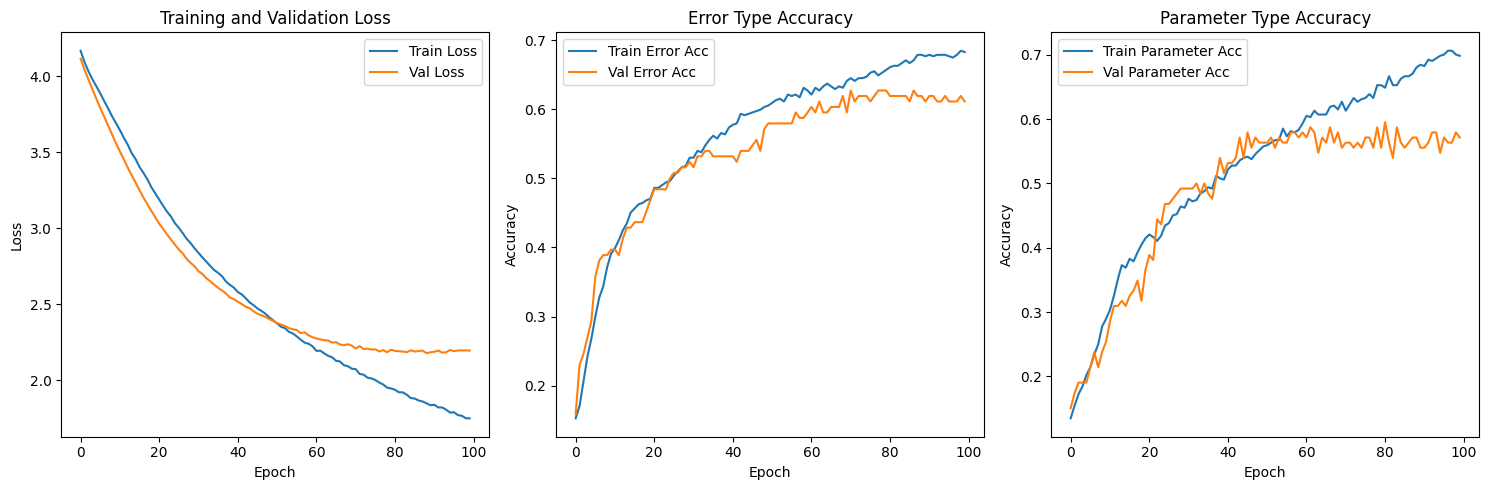

In [198]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_error, label='Train Error Acc')
plt.plot(val_acc_error, label='Val Error Acc')
plt.title('Error Type Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_acc_parameter, label='Train Parameter Acc')
plt.plot(val_acc_parameter, label='Val Parameter Acc')
plt.title('Parameter Type Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f'{results_dir}/neural_network_training_curves.png', dpi=300, bbox_inches='tight')

### Save Trained Model

In [199]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'input_dim': INPUT_DIM,
    'num_error_types': NUM_ERROR_TYPES,
    'num_error_elements': NUM_ERROR_ELEMENTS,
    'final_error_acc': final_error_acc,
    'final_parameter_acc': final_parameter_acc
}, f'{results_dir}/optical_classifier.pth')

print(f"\nModel saved to '{results_dir}/optical_classifier.pth'")
print(f"Training complete!")


Model saved to 'eda/plots/neural_network_results_20251017_000226/optical_classifier.pth'
Training complete!


### Create and Save Summary Report

In [200]:
# Create summary report
summary_report = f"""
NEURAL NETWORK TRAINING SUMMARY
================================
Timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Results Directory: {results_dir}

DATA PREPARATION
----------------
Dataset shape after removing Nominal: {len(df)} samples
Training set size: {len(df_train)} samples
Test set size: {len(df_test)} samples
Number of error types: {NUM_ERROR_TYPES}
Number of parameter types: {NUM_ERROR_ELEMENTS}
Input features: {feature_columns}

MODEL ARCHITECTURE
------------------
Input dimension: {INPUT_DIM}
Hidden layers: 128 -> 64 (with dropout 0.3)
Error type output: {NUM_ERROR_TYPES} classes
Parameter type output: {NUM_ERROR_ELEMENTS} classes
Total parameters: {sum(p.numel() for p in model.parameters())}

TRAINING CONFIGURATION
---------------------
Epochs: {config['epochs']}
Learning rate: {config['learning_rate']}
Weight decay: {config['weight_decay']}
Optimizer: {config['optimizer']}
Loss function: {config['loss_function']}
Batch size: {config['batch_size']}
Parameter loss weight: {config['parameter_loss_weight']}
Model: {config['model']}
Test selection: {config['test_selection']}
Remove small errors: {config['remove_small_errors']}

FINAL RESULTS
-------------
Error Type Classification Accuracy: {final_error_acc:.4f} ({final_error_acc*100:.2f}%)
Parameter Type Classification Accuracy: {final_parameter_acc:.4f} ({final_parameter_acc*100:.2f}%)

ERROR TYPE PERFORMANCE
---------------------
"""
for i, class_name in enumerate(le_error.classes_):
    # Get metrics for this class from the classification report
    summary_report += f"{class_name}: Class {i}\n"

summary_report += f"""
PARAMETER TYPE PERFORMANCE
-------------------------
"""
for i, class_name in enumerate(le_parameter.classes_):
    summary_report += f"{class_name}: Class {i}\n"

summary_report += f"""
FILES SAVED
-----------
- Model checkpoint: {results_dir}/optical_classifier.pth
- Encoders and scaler: {results_dir}/encoders_and_scaler.pkl
- Configuration: {results_dir}/config.json
- Training curves: {results_dir}/neural_network_training_curves.png
- Error confusion matrix: {results_dir}/neural_network_error_confusion_matrix.png
- Parameter confusion matrix: {results_dir}/neural_network_parameter_confusion_matrix.png
- Sorted parameter confusion matrix: {results_dir}/neural_network_parameter_confusion_matrix_sorted.png
- Summary report: {results_dir}/training_summary.txt

NOTES
-----
- Error type classification performs better than parameter type classification
- Some classes (Flatness, G1) have very low precision due to few samples
- Model shows good learning progression over {config['epochs']} epochs
- Weight decay helps prevent overfitting
- Parameter loss weight: {config['parameter_loss_weight']}
"""

# Save summary report
with open(f'{results_dir}/training_summary.txt', 'w') as f:
    f.write(summary_report)

print(f"\nSummary report saved to '{results_dir}/training_summary.txt'")
print(summary_report)


Summary report saved to 'eda/plots/neural_network_results_20251017_000226/training_summary.txt'

NEURAL NETWORK TRAINING SUMMARY
Timestamp: 2025-10-17 00:02:30
Results Directory: eda/plots/neural_network_results_20251017_000226

DATA PREPARATION
----------------
Dataset shape after removing Nominal: 630 samples
Training set size: 504 samples
Test set size: 126 samples
Number of error types: 9
Number of parameter types: 7
Input features: ['c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'MTF']

MODEL ARCHITECTURE
------------------
Input dimension: 37
Hidden layers: 128 -> 64 (with dropout 0.3)
Error type output: 9 classes
Parameter type output: 7 classes
Total parameters: 3248

TRAINING CONFIGURATION
---------------------
Epochs: 100
Learning rate: 0.001
Weight decay: 0.0001
Optimizer: Adam
Lo

### Plot Confusion Matrices


CONFUSION MATRICES

NEURAL NETWORK PARAMETER CONFUSION MATRIX - SORTED BY SUFFIX

Confusion matrices saved:
- Error types: eda/plots/neural_network_results_20251017_000215/neural_network_error_confusion_matrix.png
- Parameter types: eda/plots/neural_network_results_20251017_000215/neural_network_parameter_confusion_matrix.png
- Parameter types (sorted): eda/plots/neural_network_results_20251017_000215/neural_network_parameter_confusion_matrix_sorted.png

All results saved to: eda/plots/neural_network_results_20251017_000215
Summary report: eda/plots/neural_network_results_20251017_000215/training_summary.txt


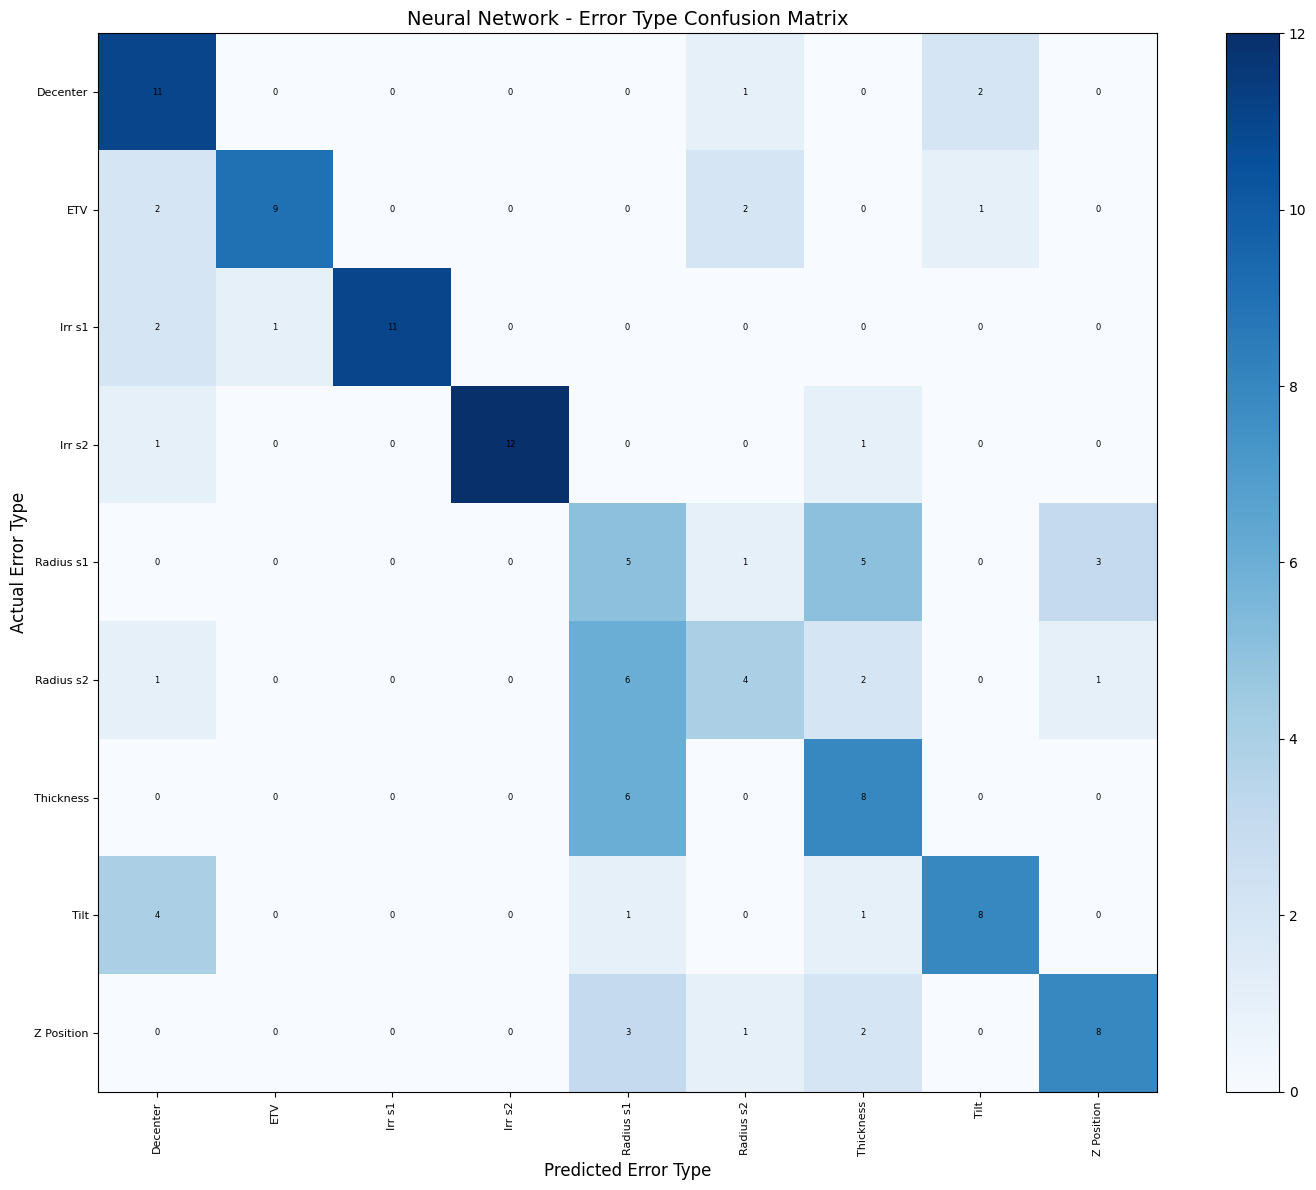

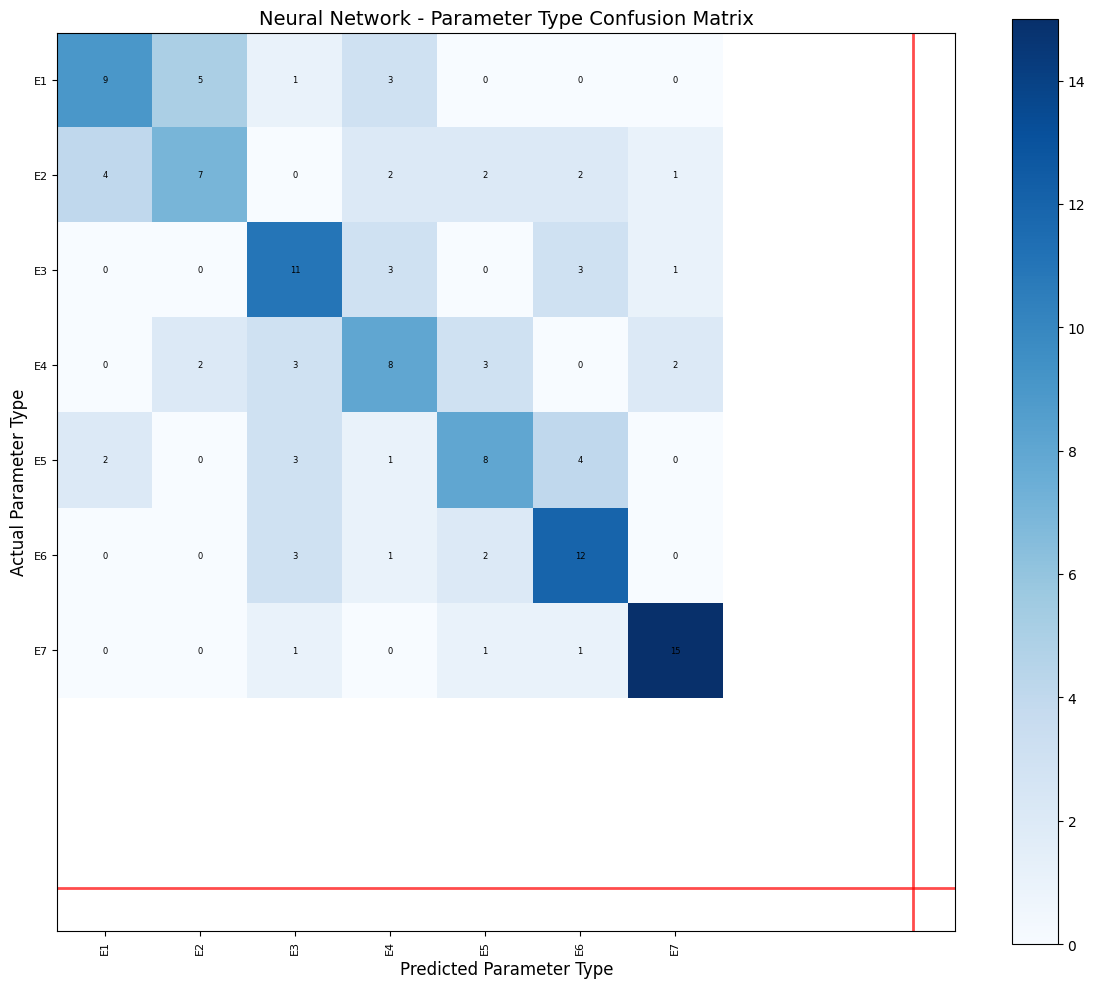

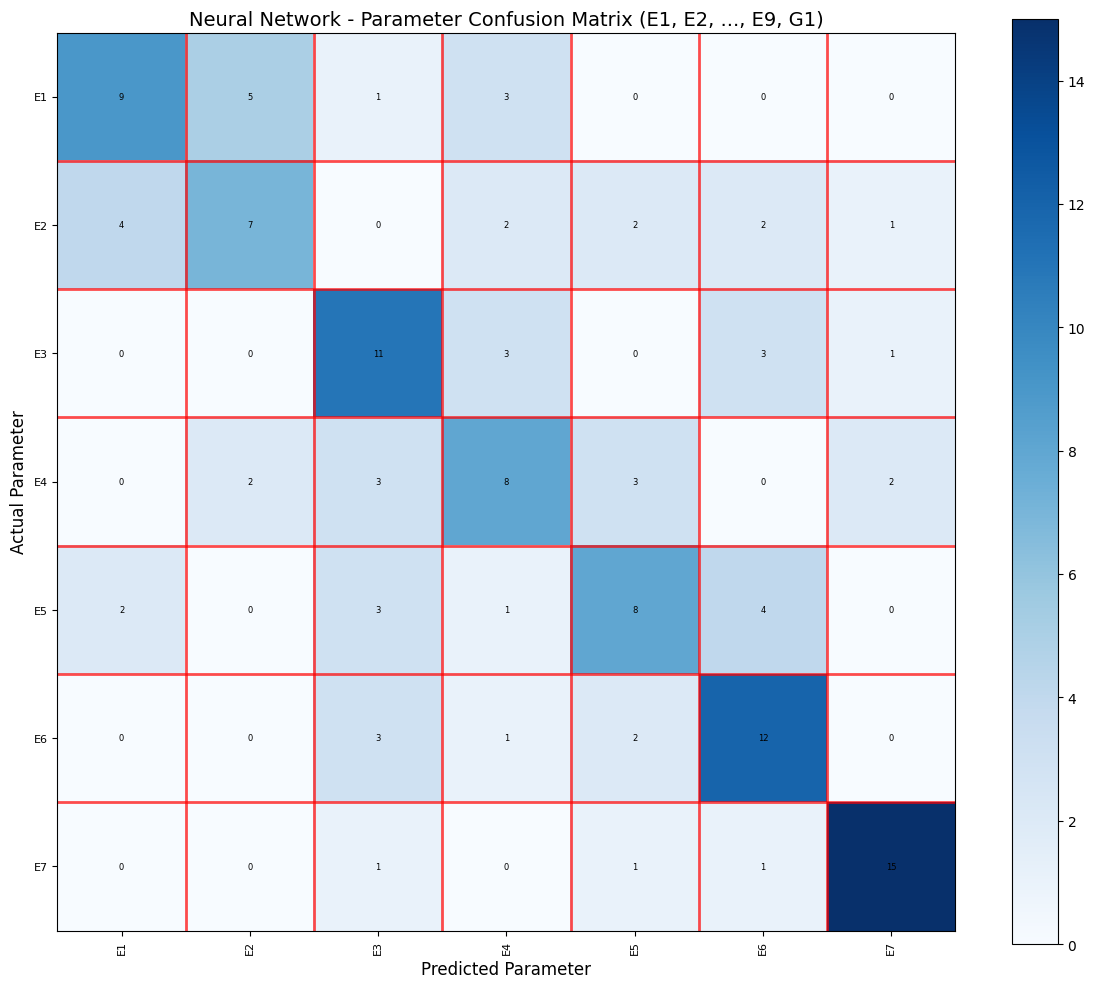

In [169]:
# Plot confusion matrices for both error types and parameter types
print(f"\n" + "="*50)
print("CONFUSION MATRICES")
print("="*50)

# Error Type Confusion Matrix
plt.figure(figsize=(15, 12))
cm_error = confusion_matrix(all_true_error, all_pred_error)

# Create the confusion matrix plot with class names
plt.imshow(cm_error, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Set ticks and labels
plt.xticks(range(len(le_error.classes_)), le_error.classes_, rotation=90, fontsize=8)
plt.yticks(range(len(le_error.classes_)), le_error.classes_, fontsize=8)

plt.title('Neural Network - Error Type Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Error Type', fontsize=12)
plt.ylabel('Actual Error Type', fontsize=12)

# Add text annotations to the confusion matrix
for i in range(len(le_error.classes_)):
    for j in range(len(le_error.classes_)):
        plt.text(j, i, str(cm_error[i, j]), ha='center', va='center', fontsize=6)

plt.tight_layout()
plt.savefig(f"{results_dir}/neural_network_error_confusion_matrix.png", dpi=300, bbox_inches='tight')

# Parameter Type Confusion Matrix
plt.figure(figsize=(12, 10))
cm_parameter = confusion_matrix(all_true_parameter, all_pred_parameter)

# Create the confusion matrix plot with class names
plt.imshow(cm_parameter, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Set ticks and labels
plt.xticks(range(len(le_parameter.classes_)), le_parameter.classes_, rotation=90, fontsize=8)
plt.yticks(range(len(le_parameter.classes_)), le_parameter.classes_, fontsize=8)

plt.title('Neural Network - Parameter Type Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Parameter Type', fontsize=12)
plt.ylabel('Actual Parameter Type', fontsize=12)

# Add text annotations to the confusion matrix
for i in range(len(le_parameter.classes_)):
    for j in range(len(le_parameter.classes_)):
        plt.text(j, i, str(cm_parameter[i, j]), ha='center', va='center', fontsize=6)

# Add red lines to separate different parameter groups (E1-E9, G1)
plt.axvline(x=8.5, color='red', linewidth=2, alpha=0.7)  # After E9, before G1
plt.axhline(y=8.5, color='red', linewidth=2, alpha=0.7)  # After E9, before G1

plt.tight_layout()
plt.savefig(f"{results_dir}/neural_network_parameter_confusion_matrix.png", dpi=300, bbox_inches='tight')

# Create sorted confusion matrix for parameter types (E1, E2, ..., E9, G1)
print(f"\n" + "="*50)
print("NEURAL NETWORK PARAMETER CONFUSION MATRIX - SORTED BY SUFFIX")
print("="*50)

def extract_suffix(name):
    """Extract suffix from parameter name (E1, E2, ..., E9, G1)"""
    return name  # Parameter names are already just the suffix

def get_suffix_order(name):
    """Get numerical order for suffix sorting"""
    if name.startswith('E'):
        try:
            return int(name[1:])  # E1 -> 1, E2 -> 2, etc.
        except:
            return 999  # For any E suffix that's not a number
    elif name == 'G1':
        return 10  # G1 comes after E9
    else:
        return 1000  # Any other suffix

# Sort parameter class names by suffix
sorted_indices = sorted(range(len(le_parameter.classes_)),
                       key=lambda i: get_suffix_order(le_parameter.classes_[i]))
sorted_parameter_names = [le_parameter.classes_[i] for i in sorted_indices]

# Reorder confusion matrix
cm_parameter_sorted = cm_parameter[sorted_indices][:, sorted_indices]

# Create the sorted confusion matrix plot
plt.figure(figsize=(12, 10))
plt.imshow(cm_parameter_sorted, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Set ticks and labels
plt.xticks(range(len(sorted_parameter_names)), sorted_parameter_names, rotation=90, fontsize=8)
plt.yticks(range(len(sorted_parameter_names)), sorted_parameter_names, fontsize=8)

plt.title('Neural Network - Parameter Confusion Matrix (E1, E2, ..., E9, G1)', fontsize=14)
plt.xlabel('Predicted Parameter', fontsize=12)
plt.ylabel('Actual Parameter', fontsize=12)

# Add text annotations to the confusion matrix
for i in range(len(sorted_parameter_names)):
    for j in range(len(sorted_parameter_names)):
        plt.text(j, i, str(cm_parameter_sorted[i, j]), ha='center', va='center', fontsize=6)

# Add red lines to separate different suffixes
current_suffix = None
for i, name in enumerate(sorted_parameter_names):
    suffix = extract_suffix(name)
    if suffix != current_suffix:
        if i > 0:  # Don't add line at the very beginning
            plt.axvline(x=i - 0.5, color='red', linewidth=2, alpha=0.7)
            plt.axhline(y=i - 0.5, color='red', linewidth=2, alpha=0.7)
        current_suffix = suffix

plt.tight_layout()
plt.savefig(f"{results_dir}/neural_network_parameter_confusion_matrix_sorted.png", dpi=300, bbox_inches='tight')


print(f"\nConfusion matrices saved:")
print(f"- Error types: {results_dir}/neural_network_error_confusion_matrix.png")
print(f"- Parameter types: {results_dir}/neural_network_parameter_confusion_matrix.png")
print(f"- Parameter types (sorted): {results_dir}/neural_network_parameter_confusion_matrix_sorted.png")

print(f"\nAll results saved to: {results_dir}")
print(f"Summary report: {results_dir}/training_summary.txt")

In [201]:

# Zip the folder
!zip -r /tmp/eda.zip eda/

# Download the zip file
from google.colab import files
files.download('/tmp/eda.zip')


  adding: eda/ (stored 0%)
  adding: eda/plots/ (stored 0%)
  adding: eda/plots/neural_network_results_20251017_000226/ (stored 0%)
  adding: eda/plots/neural_network_results_20251017_000226/training_summary.txt (deflated 60%)
  adding: eda/plots/neural_network_results_20251017_000226/optical_classifier.pth (deflated 18%)
  adding: eda/plots/neural_network_results_20251017_000226/neural_network_training_curves.png (deflated 11%)
  adding: eda/plots/neural_network_results_20251017_000226/config.json (deflated 35%)
  adding: eda/plots/neural_network_results_20251017_000226/encoders_and_scaler.pkl (deflated 19%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>